<a href="https://colab.research.google.com/github/ktgiahieu/BinPickingSimulation/blob/master/Test_2_ICLR_Overall%26Clarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# !cp /content/gdrive/My\ Drive/Dataset/kaggle.json .
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/gdrive


In [2]:
!pip install -q git+https://github.com/huggingface/peft

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00


In [3]:
!pip install -q datasets evaluate transformers sentencepiece cpm_kernels iterative-stratification==0.1.7 accelerate jiwer bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.6/416.6 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install -q py-readability-metrics textstat
!python -m nltk.downloader punkt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.3 MB/s eta 0:00:00
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import json
import glob
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd

import argparse
import glob
import os
import pandas as pd
import numpy as np

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PeftConfig,
    PeftModel
)

import evaluate
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from readability import Readability
import textstat
import os
from scipy import stats
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

num_workers = 4

# SCORES ARE AVERAGED ACROSS REVIEWS FOR EACH PAPER

In [15]:
def get_scores(conference = 'ICLR2022'):

    correctnesses = []
    technical_novelty_and_significances = []
    empirical_novelty_and_significances = []
    recommendations = []
    confidences = []
    accept_binaries = []
    flags_for_ethics_review = []

    paper_numbers = []
    for file_name in glob.glob(f"/content/gdrive/MyDrive/UPSaclay/LLMs/openreview/{conference}/reviews/*.json"):
        with open(file_name, 'r') as f:
            parsed_reviews = json.load(f)

        inv_count = -1
        while 'decision' not in parsed_reviews[inv_count]['content']:
            inv_count -=1
        accept_binary = 'accept' in parsed_reviews[inv_count]['content']['decision'].lower()
        if not accept_binary and 'reject' not in parsed_reviews[inv_count]['content']['decision'].lower():
            print(parsed_reviews[inv_count]['content']['decision'].lower())
        

        local_correctnesses = []
        local_technical_novelty_and_significances = []
        local_empirical_novelty_and_significances = []
        local_recommendations = []
        local_confidences = []
        local_flags_for_ethics_review = []
        for review in parsed_reviews:
            try:
                correctness = int(re.match(r"\d+", review['content']['correctness']).group(0))
                technical_novelty_and_significance = int(re.match(r"\d+", review['content']['technical_novelty_and_significance']).group(0))
                empirical_novelty_and_significance = int(re.match(r"\d+", review['content']['empirical_novelty_and_significance']).group(0))
                recommendation = int(re.match(r"\d+", review['content']['recommendation']).group(0))
                confidence = int(re.match(r"\d+", review['content']['confidence']).group(0))
                flag_for_ethics_review = 'NO.' not in review['content']['flag_for_ethics_review']
                
                local_correctnesses.append(correctness)
                local_technical_novelty_and_significances.append(technical_novelty_and_significance)
                local_empirical_novelty_and_significances.append(empirical_novelty_and_significance)
                local_recommendations.append(recommendation)
                local_confidences.append(confidence)
                local_flags_for_ethics_review.append(flag_for_ethics_review)

            except:
                continue
        if len(local_correctnesses) == 0:
            continue
        correctnesses.append(np.mean(local_correctnesses))
        technical_novelty_and_significances.append(np.mean(local_technical_novelty_and_significances))
        empirical_novelty_and_significances.append(np.mean(local_empirical_novelty_and_significances))
        recommendations.append(np.mean(local_recommendations))
        confidences.append(np.mean(local_confidences))
        flags_for_ethics_review.append(np.max(local_flags_for_ethics_review))
        accept_binaries.append(accept_binary)
        paper_numbers.append(file_name.split('/')[-1].split('.')[0].split('review')[1])
    return correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances, recommendations, confidences, accept_binaries, flags_for_ethics_review, paper_numbers

In [16]:
def get_parsed_papers(paper_numbers, conference = 'ICLR2022'):
    parsed_papers = []
    for paper_number in paper_numbers:
        file_name = f"/content/gdrive/MyDrive/UPSaclay/LLMs/openreview/{conference}/parsed_pdfs/paper{paper_number}.json"
        with open(file_name, 'r') as f:
            parsed_papers.append(f.read())
    return parsed_papers

In [17]:
def get_parsed_paper(paper_number, conference = 'ICLR2022'):
    file_name = f"/content/gdrive/MyDrive/UPSaclay/LLMs/openreview/{conference}/parsed_pdfs/paper{paper_number}.json"
    with open(file_name, 'r') as f:
        return f.read()

In [91]:
def get_baseline_reviewer_score(parsed_numbers, criterion, conference='ICLR2022'):
    BATCH_SIZE = 8

    model_name_or_path = "microsoft/deberta-v3-large"
    fbprize_base_model_name_or_path = f"ktgiahieu/base-{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize"
    if criterion == 'overall':
        fbprize_peft_model_name_or_path = f"ktgiahieu/{model_name_or_path.split('/')[-1]}-ptuning-logimpact-fullpaper"
        num_labels = 1
        MAX_LENGTH = 3072 # SHOULD BE HUGE AND COMBINE WITH INT8 TRAINING IN THE FUTURE
    elif criterion == 'clarity':
        fbprize_peft_model_name_or_path = f"ktgiahieu/{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize"
        num_labels = 6
        MAX_LENGTH = 1500 # SHOULD BE HUGE AND COMBINE WITH INT8 TRAINING IN THE FUTURE
    else:
        raise NotImplementedError
    task = "mrpc"
    peft_type = PeftType.P_TUNING
    device = "cuda"
    peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128, inference_mode=False)

    # ===== Tokenizers ===== 

    if any(k in model_name_or_path for k in ("gpt", "opt", "bloom")):
        padding_side = "left"
    else:
        padding_side = "right"

    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side=padding_side)
    if getattr(tokenizer, "pad_token_id") is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # ===== Dataset ======

    def prepare_input(text):
        inputs = tokenizer.encode_plus(
            text, 
            return_tensors=None, 
            add_special_tokens=True, 
            max_length=MAX_LENGTH,
            pad_to_max_length=True,
            truncation=True
        )
        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)
        return inputs


    class CustomDataset(Dataset):
        def __init__(self, parsed_numbers, conference, return_textstats=False):
            self.parsed_numbers = parsed_numbers
            self.conference = conference
            self.return_textstats = return_textstats

        def __len__(self):
            return len(self.parsed_numbers)

        def __getitem__(self, item):
            text = get_parsed_paper(self.parsed_numbers[item], conference = self.conference)
            inputs = prepare_input(text)
            if self.return_textstats:
                try:
                    r_text = Readability(text)
                    textstats_scores = [1 - (r_text.flesch().score / 100), r_text.dale_chall().score, r_text.ari().score, r_text.linsear_write().score]
                except:
                    textstats_scores = [0] * 4
                return inputs, torch.tensor(textstats_scores)

            return inputs

    def collate(inputs):
        mask_len = int(inputs["attention_mask"].sum(axis=1).max())
        for k, v in inputs.items():
            inputs[k] = inputs[k][:,:mask_len]
        return inputs

    paper_dataset = CustomDataset(parsed_numbers, conference, return_textstats = True if criterion=='clarity' else False)
    paper_dataloader = DataLoader(paper_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=num_workers, pin_memory=True, drop_last=False)

    peft_config = PeftConfig.from_pretrained(fbprize_peft_model_name_or_path)
    inference_model = AutoModelForSequenceClassification.from_pretrained(fbprize_base_model_name_or_path, return_dict=True, num_labels=num_labels, problem_type = "regression")

    # Load the Lora model
    inference_model = PeftModel.from_pretrained(inference_model, fbprize_peft_model_name_or_path)
    inference_model.print_trainable_parameters()
    inference_model.to(device)
    inference_model.eval()

    all_scores = []
    for step, inputs in enumerate(tqdm(paper_dataloader)):
        if criterion=='clarity':
            inputs, textstats_scores = inputs
            textstats_scores = textstats_scores.numpy()
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)

        batch_size = inputs['input_ids'].shape[0]

        with torch.no_grad():
            outputs = inference_model(**inputs)

        outputs = outputs.logits.cpu().numpy()

        if criterion == 'overall':
            all_scores.append(outputs)
        elif criterion == 'clarity':
            all_scores.append(np.concatenate([outputs, textstats_scores], axis=1))
        else:
          raise NotImplementedError

    all_scores = np.concatenate(all_scores, axis=0)
    if criterion == 'overall':
        all_scores = np.clip(all_scores[:, 0], 0 , 8)/8
    elif criterion == 'clarity':
        # Logistic Regressor: Correct language
        clf = LogisticRegression()
        clf.coef_, clf.intercept_, clf.classes_ = ( np.array([[ 0.56038032,  0.64963532,  0.26276436,  0.76548027,  0.94786291,
                                                              0.81975951,  0.18086392,  1.5017109 ,  0.50347458, -0.8646207 ]]),
                                                    np.array([-28.45577923]),
                                                    np.array([0., 1.]))
        correctlanguage = clf.predict_proba(all_scores)[:,1]

        # Logistic Regressor: Explanations
        clf = LogisticRegression()
        clf.coef_, clf.intercept_, clf.classes_ = ( np.array([[ 0.60207207,  0.42324284,  0.07242919,  0.63181091,  0.5677316 ,
                                                              0.55330323,  0.3465022 ,  1.36488463,  0.63845002, -1.39559633]]),
                                                    np.array([-17.59177969]),
                                                    np.array([0., 1.]))
        explantions = clf.predict_proba(all_scores)[:,1]

        # Logistic Regressor: Organization
        clf = LogisticRegression()
        clf.coef_, clf.intercept_, clf.classes_ = ( np.array([[-0.40232698, -0.35807554,  0.49696141,  0.7669115 , -0.17826834,
                                                            -0.3883086 , -0.08411565,  0.06878007, -0.00904175,  0.11215283]]),
                                                    np.array([-1.69377159]),
                                                    np.array([0., 1.]))
        organization = clf.predict_proba(all_scores)[:,1]
        # Average 3 scores
        all_scores = (correctlanguage + explantions + organization)/3
    else:
        raise NotImplementedError

    return all_scores

In [19]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [76]:
def jointplot_score(scores, recommendations, correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances):

    normalized_score = (np.array(recommendations) - 1)/8
    kendall_tau_score = kendalltau(normalized_score, scores).correlation
    g0 = sns.jointplot(x=normalized_score, y=scores, kind="hist", xlim=(0, 1), ylim=(0, 1))
    g0.ax_joint.set_xlabel(f'ICLR Ground truth\nOverall | KendallTau: {kendall_tau_score:.2f}')
    g0.ax_joint.set_ylabel('Prediction')


    normalized_score = (np.array(correctnesses) -1)/3
    kendall_tau_score = kendalltau(normalized_score, scores).correlation
    g1 = sns.jointplot(x=normalized_score, y=scores, kind="hist", xlim=(0, 1), ylim=(0, 1))
    g1.ax_joint.set_xlabel(f'ICLR Ground truth\nCorrectness | KendallTau: {kendall_tau_score:.2f}')
    g1.ax_joint.set_ylabel('Prediction')

    normalized_score = (np.array(technical_novelty_and_significances) -1)/3
    kendall_tau_score = kendalltau(normalized_score, scores).correlation
    g2 = sns.jointplot(x=normalized_score, y=scores, kind="hist", xlim=(0, 1), ylim=(0, 1))
    g2.ax_joint.set_xlabel(f'ICLR Ground truth\nTechnical N&S | KendallTau: {kendall_tau_score:.2f}')
    g2.ax_joint.set_ylabel('Prediction')

    normalized_score = (np.array(empirical_novelty_and_significances) -1)/3
    kendall_tau_score = kendalltau(normalized_score, scores).correlation
    g3 = sns.jointplot(x=normalized_score, y=scores, kind="hist", xlim=(0, 1), ylim=(0, 1))
    g3.ax_joint.set_xlabel(f'ICLR Ground truth\nEmpirical N&S | KendallTau: {kendall_tau_score:.2f}')
    g3.ax_joint.set_ylabel('Prediction')

    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(2, 2)

    mg0 = SeabornFig2Grid(g0, fig, gs[0])
    mg1 = SeabornFig2Grid(g1, fig, gs[1])
    mg2 = SeabornFig2Grid(g2, fig, gs[2])
    mg3 = SeabornFig2Grid(g3, fig, gs[3])

    gs.tight_layout(fig)

# ICLR 2022

## Plot: Overall score

In [6]:
correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances, recommendations, confidences, accept_binaries, flags_for_ethics_review, paper_numbers = get_scores(conference = 'ICLR2022')
overall_scores = get_baseline_reviewer_score(paper_numbers, criterion = 'overall', conference = 'ICLR2022')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.original_module.bias', 'classifier.original_module.weight', 'classifier.modules_to_save.def

trainable params: 22,530 || all params: 435,084,290 || trainable%: 0.005178306943695899


  0%|          | 0/328 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

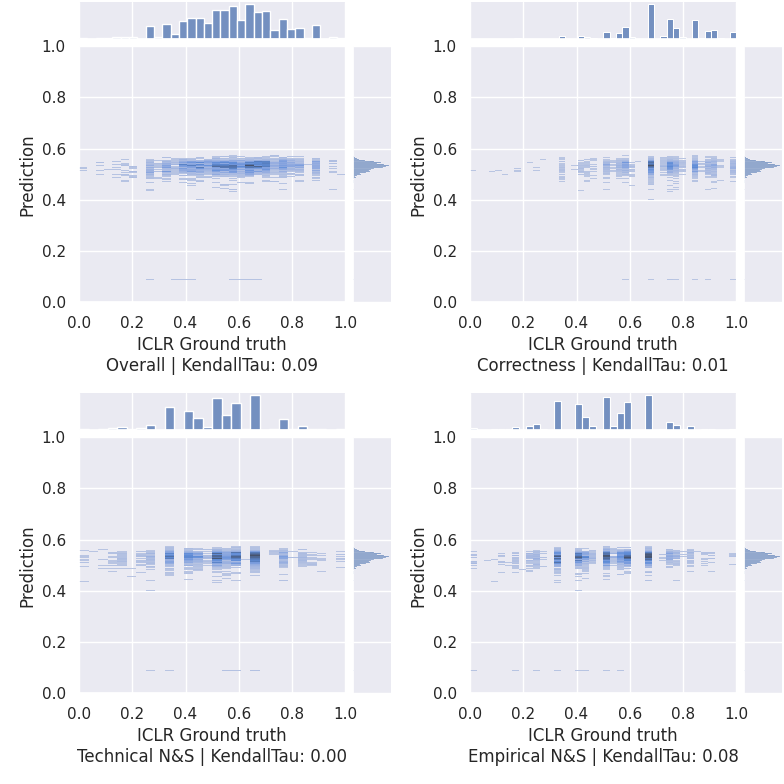

In [77]:
jointplot_score(overall_scores, recommendations, correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances)

## Plot: Clarity score

In [92]:
clarity_scores = get_baseline_reviewer_score(paper_numbers, criterion = 'clarity', conference = 'ICLR2022')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.original_module.bias', 'classifier.original_module.weight', 'classifier.modules_to_save.def

trainable params: 32,780 || all params: 435,094,540 || trainable%: 0.0075339947957057795


  0%|          | 0/326 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

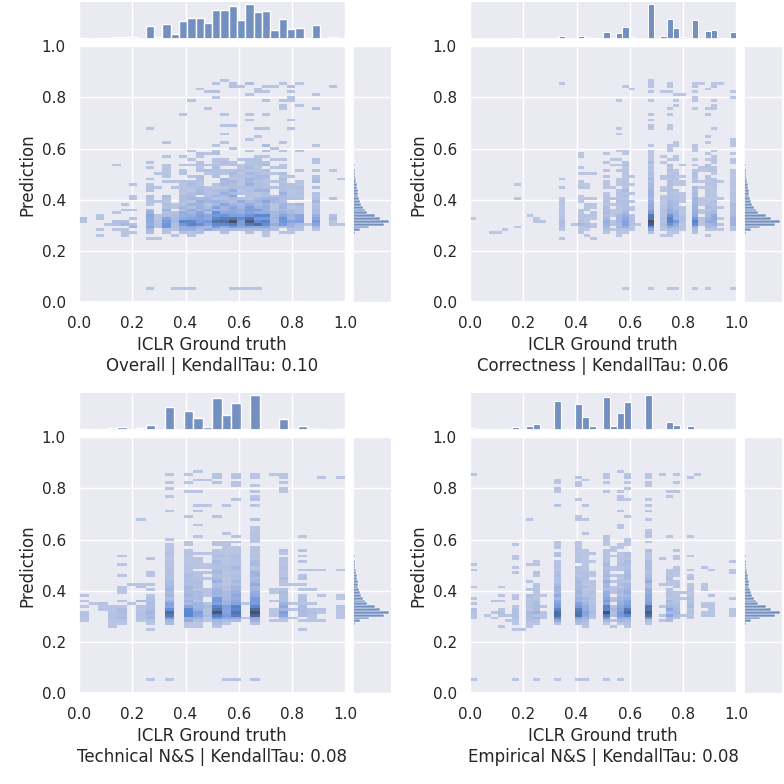

In [93]:
jointplot_score(clarity_scores, recommendations, correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances)

# ICLR 2023
(Did not run to save GPU quota)